In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import random
from pandas.tseries.offsets import BDay

In [2]:
#Vollständige Zeitreihe erzeugen
def complete_data(data, datecol='Date', freq_='B', method_='ffill'):
    try:
        df_ = data.copy()
        df_ = df.iloc[:,0:2]
        df_[datecol] = pd.to_datetime(df_[df_.columns[0]], format='%Y-%m-%d', errors='ignore')
        df_.columns = ['Date', data.columns[1]]
        daterange = pd.date_range(start=min(df_['Date']), end=max(df_['Date']), freq=freq_)
        df_ts = pd.DataFrame(daterange)
        df_ts.columns = ['Date']
        df_ts = df_ts.merge(df_, how='left', on='Date')
        print('{} fehlende Werte werden durch den zuletzt gültigen Wert ersetzt.'.format(df_ts.iloc[:,1].isna().sum()))
        df_ts = df_ts.fillna(method=method_)
        return df_ts
    except:
        print('Daten konnten nicht vervollständigt werden.')
        return data    

In [3]:
df = pd.read_excel(r'NYSE_sample.xlsx')
df.head()

,Date,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,...,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
0,2006-01-03,40.91,10.68,47.58,52.58,70.44,57.80,17.45,59.08,24.40,...,26.84,10.74,23.78,58.78,45.99,61.73,56.53,30.38,46.23,58.47
1,2006-01-04,40.97,10.71,47.25,51.95,71.17,59.27,17.85,58.91,23.99,...,26.97,10.69,24.55,58.89,46.50,61.88,56.19,31.27,46.32,58.57
2,2006-01-05,41.53,10.63,47.65,52.50,70.33,59.27,18.35,58.19,24.41,...,26.99,10.76,24.58,58.70,46.95,61.69,55.98,31.63,45.69,58.28
3,2006-01-06,43.21,10.90,47.87,52.68,69.35,60.45,18.77,59.25,24.74,...,26.91,10.72,24.85,58.64,47.21,62.90,56.16,31.35,45.88,59.43
4,2006-01-09,43.42,10.86,47.08,53.99,68.77,61.55,19.06,58.95,25.00,...,26.86,10.88,24.85,59.08,47.23,61.40,56.80,31.48,45.71,59.40


In [4]:
#Daten laden
df = pd.read_excel(r'NYSE_sample.xlsx')
df = df.iloc[:,[0,9]] #Eine Reihe auswählen
df_ts = complete_data(df, datecol=df.columns[0], freq_='B')
df_ts = df_ts.set_index('Date', drop=True)

109 fehlende Werte werden durch den zuletzt gültigen Wert ersetzt.


In [5]:
df.head()

,Date,DIS
0,2006-01-03,24.40
1,2006-01-04,23.99
2,2006-01-05,24.41
3,2006-01-06,24.74
4,2006-01-09,25.00


In [6]:
df.head()

,Date,DIS
0,2006-01-03,24.40
1,2006-01-04,23.99
2,2006-01-05,24.41
3,2006-01-06,24.74
4,2006-01-09,25.00


In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_n = df_ts.select_dtypes(include=numerics)
df_n = df_n.reset_index(drop=True)
s_dist = df_n.iloc[:,0].pct_change().dropna() #Prozentuale Veränderungen der übergebenen TimeSeries

In [8]:
s_dist.head()

1   -0.016803
2    0.017507
3    0.013519
4    0.010509
5    0.012800
Name: DIS, dtype: float64

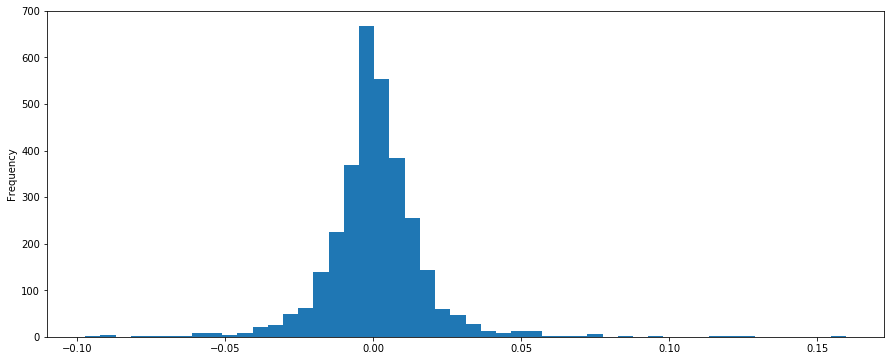

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
s_dist.plot(kind='hist', bins=50)
plt.show()            

In [10]:
df_ts.iloc[-1][0]

107.51

In [11]:
anzahl_pfade = 100
laenge_fc = 60
max_date = df_ts.index[-1]
np_r = np.random.randint(low=1, high=len(s_dist), size=(anzahl_pfade+2)*(laenge_fc+2))

In [12]:
len(np_r)

6324

In [13]:
max_date + BDay(1)

Timestamp('2018-01-01 00:00:00')

In [14]:
df_com = pd.Series(range(laenge_fc)).to_frame()
df_com.iloc[0,0]= df_ts.iloc[-1][0] * (1+random.choice(s_dist))
df_com = df_com[np.repeat(df_com.columns.values,anzahl_pfade)].copy()
df_com.columns=range(anzahl_pfade)

In [15]:
j = 0
for i in range(anzahl_pfade):
    for k in range(laenge_fc-1):
        j = j+1
        df_com.iloc[k+1,i] = df_com.iloc[k,i] * (1+s_dist[np_r[j]])

In [16]:
df_com = df_com.set_index(pd.date_range(start=max_date+BDay(1), periods=len(df_com), freq='B'), drop=True)

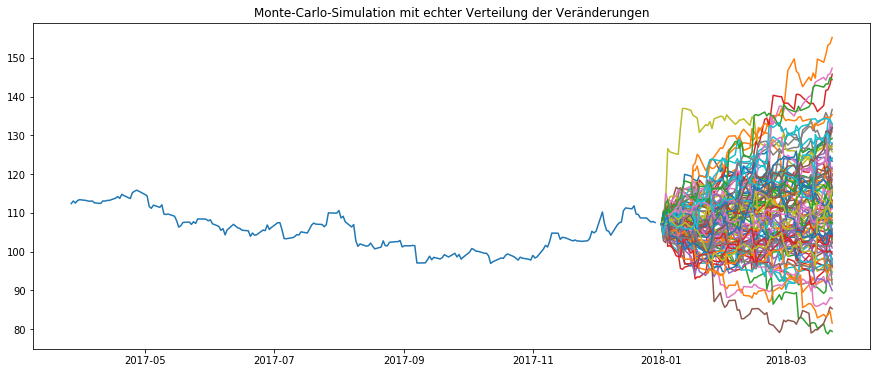

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
plt.plot(df_ts.iloc[-200:].index, df_ts.iloc[-200:].values)
plt.plot(df_com.index, df_com.values)
plt.title('Monte-Carlo-Simulation mit echter Verteilung der Veränderungen')
plt.show()

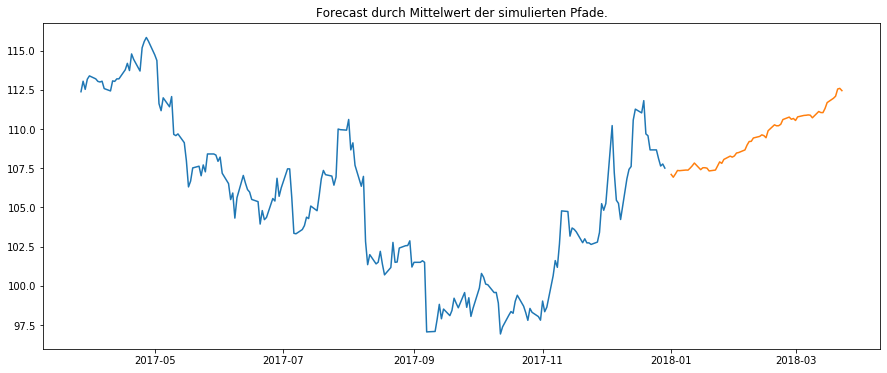

In [18]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
plt.plot(df_ts.iloc[-200:].index, df_ts.iloc[-200:].values)
plt.plot(df_com.index, df_com.values.mean(axis=1))
plt.title('Forecast durch Mittelwert der simulierten Pfade.')
plt.show()